

Рассмотрим сверточные нейронные сети (convolutional neural networks, convnets).

## Введение в сверточные сети
Рассмотрим очень простой пример.

При классификации MNIST с использованием полносвязной сети мы достигли точности 97.8% на тестовой выборке. 
Несмотря на то, что первая сверточная сеть будет учебной, её точность будет превосходить точность, полученную в результате классификации полносвязной сетью.

Рассмотрим базовую сверточную сеть. Это стек слоев *Conv2D* и *MaxPooling2D*. Важно, что сверточная нейронная сеть принимает на входн тензор размерности (image_height, image_width, image_channels). В нашем случае, мы сконфигурируем сверточную сеть обрабатывать вход размерности (28, 28, 1), что является форматом изображений MNIST. Это делается передачей аргумента
    input_shape = (28,28,1)
первому слою.

In [2]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Using TensorFlow backend.


In [3]:
 model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Можно заметить, что выходом каждого слоя *Conv2D* и *MaxPooling2D* является трехмерный тензор (height, weight, channels).

Размерности, соответствующие ширине и высоте имеют тенденцию сжиматься по мере углубления в сети. Число каналов (channels) управляется первым аргументом, передаваемым на слой *Conv2D* (например, 32 или 64).

Следующим шагом является передача последнего тензора (размерности (3,3;64)) в плотную нейронную сеть для классификации. 

Такие сеть уже рассматривались прежде: стек плотных слоёв (Dense). Классификаторы обрабатывают векторы, являющиеся одномерными, в то время как наш выходной тензор имеет размерность 3. Поэтому, сперва нужно преобразовать 3х мерный выход к одномерному, и лишь затем добавить плотные слои.
Подобное "выпрямление" выполняется слоем *Flatten*.

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Мы проводим классификацию на 10 классов, поэтому последний слой будет иметь 10 выходов с функцией активации softmax.

Еще раз взглянем на модель:

In [5]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

Заметим, что тензор (3, 3, 64) был "выпрямлен" в вектор размерности (576, ), перед передачей в плоные слои.

Теперь, обучим сверточную нейронную сеть на наборе MNSIT.

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

60000/60000 [==============================] - 59s - loss: 0.1697 - acc: 0.9479    
Epoch 2/5
60000/60000 [==============================] - 59s - loss: 0.0473 - acc: 0.9855    
Epoch 3/5
60000/60000 [==============================] - 59s - loss: 0.0325 - acc: 0.9896    
Epoch 4/5
60000/60000 [==============================] - 64s - loss: 0.0243 - acc: 0.9926    
Epoch 5/5
60000/60000 [==============================] - 66s - loss: 0.0195 - acc: 0.9944    


In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

 9920/10000 [============================>.] - ETA: 0s

0.9929

В то время как плотная нейронная сеть имела точность 97.8%, наша простая сверточная сеть имеет точность 99.3%!

Но почему эта простая сверточная сеть работает так хорошо, по сравнению с полносвязной плотной моделью?

Рассмотрим подробнее эти слои: *Conv2D* и *MaxPooling2D*.


Операция свертки (конволюции)

Фундаментальное различие между полносвязным слоем (densety-connected layer) и сверточным слоем (convolution layer) состоит в следующем: плотные слои изучают глобальные паттерны в своем входном пространстве атрибутов (напрмер, для MNIST паттерны включают все пиксели), в то время как сверточные уровни пытаются обучаться локальным паттернам, в случае изображений, паттерны находятся в небольшим двумерном окошке входовю
Например:
![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/local_patterns.jpg)

Эта ключевая характеристика дает сверточным сетям два интересных свойства:
* Изучаемые паттерны инварианты к перемещению (translation-invariant), то есть после обучения определенного паттерна в правом верхнем углу изображения, сверточная сеть способно "изнавать" этот паттерн где угодо, например в верхнем левом углу.
Полносвязная сеть пришлось бы изучать шаблон заново, если он появится в новом месте. Это делает сверточные сети очень эффективными при обработке изображений (поскольку визуальный мир принципиально нвариантен по отношению к перемещению): им нужна меньшая тренировочная выборка, для обучения репрезентаций, имеющих способность к генерализации.
* Они могут изучать **пространственные иерархии паттернов (spatial hierarchies of patterns)**. Первый сверточный слой будет обучаться небольшим локальным паттернам, таким как углы, но второй сверточный слой будет изучать паттерны построенные на паттернах предыдущего уровня. Это позволяет сверточным нейронным сетя обучаться достаточно сложным и абстрактным визуальным концптам (поскольку визуальный мир в своей основе пространственно иерархичен).

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/visual_hierarchy_rsd.jpg)

Свертки оперируют трехмерными тензорами, называемыми картами атрибутов (feature maps) с двумя пространственными атрибутами (высота и ширина), а также ось глубины (также называемая осью каналов - channel axis).

Для RGB изображения, размерность "глубины" будет равно 3, поскольку изображение имеет 3 цветовых канала: красный, зеленый, синий. Для черно-белых изображений (аналогичных MNIST), глубина будет равна 1 (градации серого).

Операция свертки извлекает patches из **входной карты атрибутов (input feature map)** и применяет то же преобразование ко всем patches, порождая **выходную карту атрибутов (ouput feature map)**. Эта выходная карта атрибутов остается трехмерным тензором: она имеет длину и ширину. Её длина может быть произвольной, поскольку выходная глубина - это параметр слоя, и разные каналы по этой оси глубины больше не соответствуют конкретным цветам (как для входного RGB), они предназначены для того, что мы называем **фильтрами**. Фильтры кодируют специфические аспекты входных данных. 
Например, одиночный фильтр может кодировать высокоуровневую концепцию "присутствие лица на входе".

В MNIST, первый сверточный слой берет карту атрибутов (feature map) размера (28,28,1) и порождает карту атрибутов (feature map) размерности (26, 26, 32), т.е. вычисляет 32 фильтра над входами. Каждый из этих 32 выходных каналов содержит сетку значений 26x26, которая является картой ответов (reponse map) фильтра над входом, показывая ответ паттерна фильтра на разных локациях входа.

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/response_map_rsd.png)
Рис. 3. КОнцепция карты ответов (response map): карта ответов это двумерное отображение присутствия паттерна в разных позициях входного изображения.

Это то, что в действительности означает термин "карта атрибутов": каждая размерность по оси глубины является атрибутой (feature) или филтром, и двумерный тензор output(:,:,n]  - это двумерная пространственная карта (2D spatial map) ответа этого фильтра на входные данные.

Операции свертки определяются двумя ключевыми параметрами:
* Размер patches, извлекаемых из входных данных (обычно, 3x3 или 5x5);
* Глубина выходной карты атрибутов (output feature map), т.е. число фильтров, вычисляемых сверткой. 

В Keras, эти параметры передаются слоям Conv2D первыми аргументами:
    Conv2D(output_depth, (window_height, window_width))
    
Свертка работает путем "сдвига" окон размера 3x3 (или 5x5) нам трехмерной входной картой атрибутов, останавливаясь над всевозмодными локациями и извлекая тремерный patch окружающих атрибутов (размерность (window_height, window_width, input_depth)). Каждый такой трехмерный patch преобразуется через тензорное произведение с той же самой матрицей весов, называемой "ядром свертки" (convilution kernel) в одномерный вектор размера (ouput_depth, ).

Все эти векторы затем пространственно перемещаются в трехмерную выходную карту (3D ouput map) размера (heigh, width, output_depth). Каждая пространственная локация (spatial location) в выходной карте атрибутов (output feature maps)соответствует той же локации во входной карте атрибутов (input feature map).

Например, правый верхний угол выходного тензора, содержит информацию о правом верхнем угле входного тензора).

Так, при окне размером 3x3, вектор output[i,j,:] идет с 3D patch 
    input[i-1:i+1, j-1:j+1, : ]
    
Процесс детальнее приведен на рисунке:
![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/how_convolution_works.png)

Обратите внимание, что высота и ширина входа могут отличаться от входной высоты и ширины . Это происходит по двум причинам:
* Граничиные эффекты, которым можно противопоставить наполнение (padding) входной карты атрибутов;
* Использование *strides*;

#### Понимание граничных эффектов (border effects) и наполнения (padding)

Рассмотрим карту атрибутов 5x5 (всего 25 плиток). Есть только 9 различных плиток вокруг, где можно центрировать окно 3x3, формируя сетку 3x3.

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/3x3_patches_in_5x5_input.png)

Поэтому, выходная карта атрибутов будет размера 3x3: она немного сокращается, ровно на две плитки рядом с каждым измерением. 

Для примеров выше также можно увидеть "граничный эффект" в действии: мы начинаем со входа 28x28, который становится 26x26 после первого слоя свертки.

Если вы хотите получить пространственную карту атрибутов (ouput feature map) с той же пространственной размерностью как и на входе, можно использовать т.н. **наполнение (padding)**. Наполнение (padding) состоит в добавление соответствующего числа строк и столбцов по каждую сторону входной карты атрибутов (input feature map) так, что становится возможным настроить центральное сверточное окно вокруг каждой входной плитки. 

Для окна 3x3, добавляется один столбец справа, один столбец слева, и по одной строке сверху и снизу. Для окна 5x5 будет две строки.

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/padding_of_5x5_input.png)

В слое Conv2D, наполнение (padding) конфигурируется через аргумент 
    padding
который может принимать два значения: 
    "valid"
что означает отсутствие наполнения (используются только валидные локации окна) и 
    "same" 
, что означает наполнять таким способом, чтобы получать выход с той же длиной и шириной, как и вход.

По умолчанию, аргумент padding принимает значение "valid".

##### Convolution strides

Еще одним фактором, который может влиять на выходной размер - это нотация stride. До сих пор, в нашем описании конволюции, мы предполагали, что центральная плитка окон свертки (central tile if the convolution windows) будет сплошные (contiguous).

ОДнако, дистанция между двумя последовательными окнами, фактически является *параметром свертки*, называемым **stride**, который по умолчанию равен единице.

На рисунке 7 можно увидеть patches извлеченные сверткой с параметром stride = 2 на входе 5x5 (без наполнения):

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/strides.png)

Использование stride = 2 означает, что ширина и высота карты атрибутов (feature map) снижается с коэффицентом 2 (помимо любых изменений, вызванных эффектом границ). Strided convolutions редко используются на практике, хотя они могут быть полезны для некоторых моделей и нужно быть знакомыми с этой конценпцией.

Для того, чтобы скомпоновать карту атрибутов (downsample feature maps), помимо strides, можно использовать операцию max pooling.

https://stackoverflow.com/a/34643081/1635491

## Операция max pooling

В примере сверточной сети можно также заметить, что размер карты атрибутов (feature maps) уменьшается вдвое после каждого слоя MaxPooling2D.

Например, перед первым слоем MaxPooling2D, размерность карты атрибутов составляет 26x26, но операция MaxPooling сокращает её до 13x13. В этом и состоит роль max pooling: достаточно агрессивно скомпоновать карту атрибутов (downsample feature maps), подобно strided convolutions.

Max pooling состоит в извлечении "окон" из входной карты атрибутов и вывелении максимального значения для каждого канала. Концептуально, это напоминает свертку, за исключением что вместо преобразования локальных patches через обученное линейное преобразование (сверточное ядро), они преобразуются посредством фиксированной тензорной операции max. Большая разница со сверткой заключается в том, что max pooling обычно выполняется в окне 2x2 и stride=2, поэтому уменьшение (downsample) карты атрибутовпроисходит в два раза.
С другой стороны, свертка обычно выполняется с окном 3x3 и без stride (т.е. stride=1).

Почему мы уменьшаем карту атрибутов (downsample feature maps) таким образом? Почему бы просто не удалить слои max pooling и сохранить достаточно большие карты атрибутов до конца? 

Рассмотрим эту возможность. Тогда база свертки нашей модели будет выглядеть сл. образом:


In [9]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [10]:
model_no_max_pool.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Что не так с этой установкой?

* Она не способна изучать пространственную иерархию атрибутов. Окно 3x3 в трех слоях будет содержать только информацию, поступающую из окон 7x7 в исходном входе. Высокоуровневые паттерны, получаемые сверточной сетью будут оставаться очень малыми по отношению к начальным входным данным, что может быть недостаточно для классификации чисел (пытаясь распознать цифры только через окна 7x7 пикселей). Нам нужны функции последнего слоя свертки, содержащие информацию о совокупности входных данных!

* Финальная карта атрибутов имеет 22x22x64 = 31 000 коэффициентов на один объект выборки. Это очень много. Если мы должны были бы "выпрямить" (flatten) его для использования в плотном слое (Dense layer) с 512 скрытыми нейронами, тогда слой бы имел 15.8 миллиона параметров. Это чрезвычайно большое число для такой малой модели и в результате приведент к переобучению.

Итак, основная причина понижения дискретизации (downsampling) - понижение числа коэффициентов карты атрибутов, а также индуцирование иерархии пространственных фильтров путем создания последовательных сверточных слоев на всё более крупных окнах (в терминах доли оригинального входа, который они покрывают).

Следует отметить, что max pooling не единственный способ для достижения понижения дискретизации (downsampling). Один из способов - использовать strides на предыдущем слое свертки.

Еще один способ можно использовать average pooling (усредняющий пулинг) вместо максимального (max pooling), где каждый входной локальный patch преобразуется взятием среднего значения каждого канала над patch'ем, а не максимального значения. По сути, причина этого заключается в том, что функции имеют тенденцию кодировать пространственное "присуствие" некоторого паттерна или концепции над разными фрагментами карты атрибутов, и более информативно рассматривать максимальное присутствие различных атрибутов, а не их усредненное присутствие. Поэтому, наиболее разумная стратегия подвыборки - это сначала породить плотную карту атрибутов (посредством unstrided convolutions) и затем посмотреть на максимальную активацию атрибутов над небольшими patches, а не поиска редких окон на входных данных (sparser window of the windows) (посредством strided convolutions) или усредненением входных patches, что может привести к потере информации о присутствии атрибута, или "размыть" её. 

Сейчас Вы имеете представление об основах конволюционных (сверточных) нейронных сетей.


## Обучение сверточной нейронной сети с нуля на малом наборе данных

Необходимость обучения модели классификации изображений используя небольшой объем данных - это рядовая ситуация с которой вы скорее всего столкнетесь на практике, если когда-либо будете заниматься приложениям компьютерного зрения.

Небольшй объем может означать что угодно от нескольких сот до нескольких десятков тысяч изображений. Разберем практический пример, и будем классифицировать изображения как собак или кошек.  В наборе данных, содержащим 4000 изображений (2000 собаки, 2000 кошки).

Будем использовать 2000 изображений для обучения, 1000 для валидации и 1000 для тестирования.

Основная цель - научиться обучать новую модель с нуля на небольшом объеме данных. Мы начнем с наивного обучения небольшой конволюционной сети на 2000 тренировочных примерах без какой-либо регуляризации, установив baseline которого можно достичь.

### Релевантность использования глубокого обучения для проблем с небольшим объемом данных

Одной из фундаментальных характеристик глубокого обучения является то, что оно может самостоятельно находить интересные атрибуты в обучающем наборе, без необходимости конструирования атрибутов (manual feature engineering). К сожалению, это может быть достигнуто только в том случае, когда имеется большой объем тренировочных данных. Это также истинно для задач, где входные данные обладают высокой размерностью (например, изображения).

Однако, что составляет "большой объем" - относительно размера и глубины сети, которую Вы хотите обучить. Невозможно обучить сверточную нейронную сеть решать сложную проблем с помощью нескольких десятков объектов тренировочной выборки, однако несколько сотен потенциально может быть достаточно, если модель небольшая, регуляризована и если задача не очень сложная. Поскольку сверточные нейронные сети обучаются локальным паттернам, инвариантным к перемещению (translation-invariant) атрибутам, они очень эффективны для перцептивных проблем. Обучение сверточной нейронной сети с нуля на небольшом объеме изображений может давать неплохие результаты, несмотря на относительную нехватку данных, без необходимости конструкции атрибутов.

#### Загрузка данных

Набор данных появился на сайте Kaggle.com в ходе соревнования по  компьютернму зрению в 2013 году, когда сверточные нейронные сети еще не приобрели популярность.

Набор данных можно скачать здесь: www.kaggle.com/c/dogs-vs-cats/data
Сжатый файл с тренировочной выборкой занимает 543 Мб в архиве. После загрузки и декомпрессии, мы создадим новые подвыборки: 
* тренировочную выборку (1000 объектов каждого класса);
* тестовую выборку (500 объектов каждого класса);
* контрольную выборку (500 объектов каждого класса);



In [4]:
import os, shutil

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = "C:\\Users\\oleg-\\Downloads\\train"

# The directory where we will
# store our smaller dataset
base_dir = '.\\CatsVSDogs\\'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)


In [ ]:
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Сделаем проверку количества изображений в каждой подвыборке:

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500


Итак, у нас 2000 объектов тренировочной выборки, 1000 контрольных изображений и 1000 тестовых изображений. Выборка сбалансирована, решается задача бинарной классификации.

#### Построение нейронной сети

Будем использовать ту же структуру, что и прежде - сврточная нейронная сеть будет стеком чередующихся слоев Conv2D (с функцией активации relu) и MaxPooling2D.

Однако, сейчас у нас достаточно большие изображение, поэтому увеличим нейронную сеть добавив еще одну пару Conv2D + MaxPooling2D.

Это необходимо как для увеличения пропускной способности сети, так и для дальнейшего уменьшения размера карт атрибутов (feature maps), чтобы они не были слишком большими по достижении слоя Flatten.

Мы начинаем со входа размера 150x150 (несколько произвольный выбор) и заканчиваем с картой атрибут размера 7x7 еред слоем Flatten.

Заметим, что глубина карты атрибут в сети постоянно увеличивается: от 32 до 128, в то время как размер карты атрибутов уменьшается (от 148x148 до 7x7). Это паттерн, который можно увидеть в большинстве сверточных сетей.

Поскольку решается задача бинарной классификации, нейронная сеть завершается со слоем состоящим из одного нейрона с функцией активации Sigmoid.


In [1]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

На этапе компиляции, мы начинаем с оптимизатора RMSProp. Поскольку мы завершили нейронную сеть одним сигмоидальным нейронном, будем использовать в качестве функции потерь бинарную категориальную кросс-энтропию.

In [8]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#### Предобработка данных

Данные должны быть приведены в соответствующую форму - должно произойти преобразование входных данных в тензора с плавающей точкой, чтобы передать их нашей сети.
Сейчас данные на жестком диске как JPEG файлы, поэтому должна быть сл. последовательность шагов:
* считать изображения;
* декодировать JPEG контент в сетку пикселей RGB;
* конвертировать их в вещественные тензора;
* произвести перенормировку пиксельных значений (от 0 до 255) в интервал [0;1].

Keras имеет утилиты, позволяющие проводить эти шаги автоматически! 
Модуль отвечающий за обработку изображений 
    keras.preprocessed.image
    
В частности, он содержит класс ImageDataGenerator, который достаточно быстро устанавливает генератор Python'a способный преобразовывать файлы изображений на диске в пакеты предобработанных тензоров.

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Теперь посмотрим на выход одного из генераторов: он порождает пакеты (batches) 150x150 RGB изображений (20, 150, 150, 3) и бинарные метки (20,).

20 - это количество объектов в каждом пакете (batch size). 

In [10]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Обучим нашу модель с использованием генератора. 

Это делается с помощью метода 
    fit_generator,
который аналогичен методу
    fit
для генераторов данных. Поскольку с помощью генератора данный генерируются бесконечно, то генератору нужно знать, сколько выборок нужно сделать до объявления эпохи.

За это отвечает аргумент 
    steps_per_epoch:
после того, как получено steps_per_epoch пакетов от генератора, процесс обучения переходит к следующей эпохе. 

В нашем случае, пакеты состоят из 20 объектов выборке, поэтому будет взято 100 пакетов, пока мы не доберемся до нашей цели в 2000 объектов.
При использовании
    fit_generator, 
можно передать аргумент 
    validation_data
аргумент, аналогичный тому, который использовался с методом 
    fit.
Важно, что этот аргумент может быть генератором, но также может быть кортежем массивов NumPy. При использовании генератора также нужно указать 
    validation_steps.

In [11]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 128s - loss: 0.6864 - acc: 0.5510 - val_loss: 0.6669 - val_acc: 0.6130
Epoch 2/30
100/100 [==============================] - 121s - loss: 0.6462 - acc: 0.6295 - val_loss: 0.6330 - val_acc: 0.6470
Epoch 3/30
100/100 [==============================] - 120s - loss: 0.5994 - acc: 0.6765 - val_loss: 0.5981 - val_acc: 0.6730
Epoch 4/30
100/100 [==============================] - 121s - loss: 0.5713 - acc: 0.7090 - val_loss: 0.6018 - val_acc: 0.6770
Epoch 5/30
100/100 [==============================] - 121s - loss: 0.5475 - acc: 0.7160 - val_loss: 0.6103 - val_acc: 0.6500
Epoch 6/30
100/100 [==============================] - 118s - loss: 0.5199 - acc: 0.7405 - val_loss: 0.5543 - val_acc: 0.7040
Epoch 7/30
100/100 [==============================] - 115s - loss: 0.5028 - acc: 0.7475 - val_loss: 0.6025 - val_acc: 0.6770
Epoch 8/30
100/100 [==============================] - 120s - loss: 0.4842 - acc: 0.7660 - val_loss: 0.5459 - val_acc: 0.7060


Хорошей практикой является сохранение модели после обучения:

In [12]:
model.save('cats_and_dogs_small_1.h5')

Построим графики функции потерь и точности модели для тренировочной и контрольной выборки во время обучения:

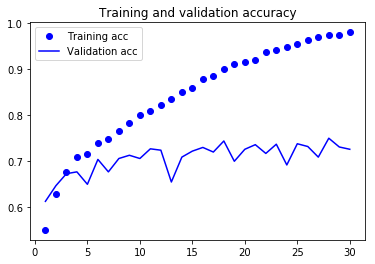

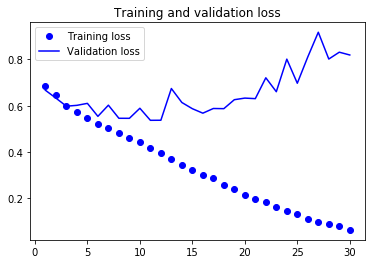

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Графики характеризуют переобучение. ТОчность тренировочной выборки возрастает линейно, пока не достигнет почти 100%, в то время, как точность на контрольной выборке составляет 70-72%. Значение потерь достигает минимума после 5 эпох, затем останавливается, а с течением времени начинает расти. В то же время потери на тренировочной выборки продолжают линейно убывать, пока не достигнет 0.

Поскольку у нас есть небольшой объем тренировочной выборки (2000 объектов), переобучение является для нас проблемой номер 1.

Нам уже известны такие техники преодоления переобучения как прореживание (dropout) и $L_2$-регуляризация. Рассмотрим еще одну технику, специфичную для компьютерного зрения, используемую почти повсеместно пр обработке изображений с использованием моделей глубокого обучения: **увеличение данных (data augmentation)**.

### Использование увеличения данных (data augmentation)

Переобучение обусловлено тем, что мы имеем слишком малый объем тренировочной выборки, что делает неспособным обучение модели, способной провести генерализацию на новые данные. Если бы мы имели бесконечные данные, наша модель учитывала бы всевозможные аспекты в распределении данных и мы бы никогда не переобучились. Методика Data augmentation использует подход, позволяющий генерировать больше обучающих данных из существующей тренировочной выборки, путем "увеличения (augmenting)" числа тренировочных примеров с помощью ряда случайных преобразований, дающих правдоподобные образы.
Цель состоит в том, что во время обучения наша модель никогда не получила бы одну и ту же картину дважды. Это поможет получить доступ к большему количеству аспектов в данных и приведет к лучшей генерализации.

В Keras это может быть выполнено при помощи конфигурирования ряда случайных преобразований на изображениях: класс ImageDataGenerator.


In [14]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

У класса есть несколько доступных опций (полный список в документации Keras).

* *rotation_range* - значение в градусах (0-180), диапазон в котором производится случайный поворот изображений.
* *width_shift* и *height_shift* - диапазоны (как доля общей высоты и ширины) в пределах которого можно произвольно translate изображения по вертикали и горизонтали.
* *shear_range*  случайное применение преобразований сдвига;
* *zoom_range* случайное масштабирование внутри изображения.
* *horizontal_flip* случайное отображение половины изображения по горизонтали - елевантно при отсутствии допущений о горизонтальной ассиметрии.
* *fill_mode* - стратегия, используемая для заполнения новых созданных пикселей, который могут появляться после поворота или сдвига по ширина/высоте;

Посмотрим на дополненные изображения:

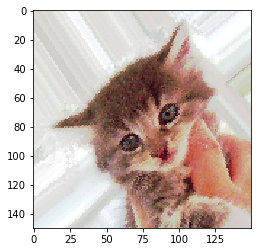

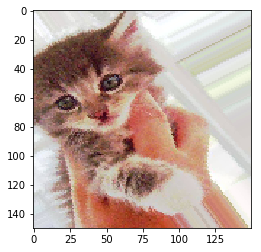

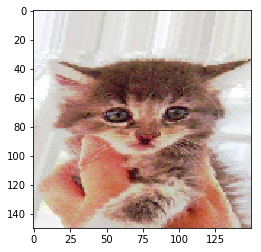

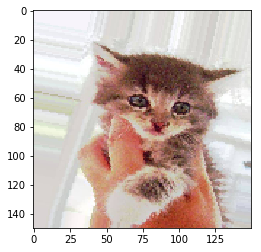

In [15]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

При обучении сети с использованием методики data augmentation наша сеть никогда не увидит дважды один и тот де объект. Однако, входные данные, которые она увидит по прежнему будет взаимосвязаны, поскольку они образованы из небольшого числа оригинальных изображений - мы не можем порождать новую информацию, а лишь использовать варианты уже существующей информации. Таким образом, этого может быть недостаточно, чтобы избавиться от переобучения.

Продолжим борьбу с переобучением, добавив слой прореживания (Dropout) к нашей модели, перед полносвязным классификатором.

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Обучим нейронную сеть с использованием техники data augmentation и прореживания:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 209s - loss: 0.6921 - acc: 0.5141 - val_loss: 0.6766 - val_acc: 0.5400
Epoch 2/100
100/100 [==============================] - 196s - loss: 0.6794 - acc: 0.5606 - val_loss: 0.6584 - val_acc: 0.5928
Epoch 3/100
100/100 [==============================] - 201s - loss: 0.6652 - acc: 0.5928 - val_loss: 0.6499 - val_acc: 0.5741
Epoch 4/100
100/100 [==============================] - 193s - loss: 0.6522 - acc: 0.6084 - val_loss: 0.6549 - val_acc: 0.5915
Epoch 5/100
100/100 [==============================] - 201s - loss: 0.6360 - acc: 0.6334 - val_loss: 0.6008 - val_acc: 0.7049
Epoch 6/100
100/100 [==============================] - 187s - loss: 0.6275 - acc: 0.6384 - val_loss: 0.5951 - val_acc: 0.6865
Epoch 7/100
100/100 [==============================] - 186s - loss: 0.6097 - acc: 0.6631 - val_loss: 0.5817 - val_acc: 0.6796
Epoch 8/100
100/100 [=============

Сохраним модель - мы будем использовать её при визуализации нейронной сети. И вновь построим графики потерь и точности на тренировочной и контрольной выборке.

In [ ]:
model.save('cats_and_dogs_small_2.h5')

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Благодаря этим техникам мы больше не переобучаемся (см. графики). Мы можем достигать точности 82%, 15% относительное улучшение над нерегуляризованной моделью.

Используя техники регуляризации и настройки параметров сети (число фильтров на сверточном слое, или число слоев в сети), мы можем получить еще большую точность, достигая 86-87%.

Однако будет очень сложно поднять точность, обучив нейронную сеть с нуля, поскольку у нас очень мало данных для работы.

#- Advanced level : Использование предобученной сверточной сети

Общий и достаточно эффективный подход на небольших объемах тренировочных данных (применительно к изображениям) - использовать предобученную сеть. Предобученная сеть - это просто сохраненная сеть, обученная на огромном наборе данных, обычно для некоторой крупномасштабной задаче классификации изображений.

Если исходный набор изображений достаточно большой, и общий, тогда пространственная иерархия атрибутов (spatial feature hierarchy) в предобученной сети будет эффективно действовать как общая модель нашего визуального мира, и поэтому её атрибуты могут быть полезны для различных задач компьютерного зрения, даже если новые задачи будут включать совершенно разные классы, отличающиеся от исходной задачи. Например, сеть может быть обучена на ImageNet (где классы в основном животные и бытовые предметы) и затем использовать предобученную сеть, например, для идентификации предметов мебели на изображениях. Такая переносимость обученных атрибутов по отношению к различным проблемам являетсся ключевым преимуществом глубокого обучения по сравнению с большинством более старых подходов к обучению, что делает глубокое обучение эффективным для задач с небольшим количеством данных.

Рассмотрим достаточно большую сверточную сеть обученную на наборе данных ImageNet (1.4 миллиона размеченных изобажений и более 1000 различных классов). ImageNet содержит большое число классов животных, включая различные виды кошек и собак, и поэтому, можно ожидать достаточно хороших показателей качества для решения задачи бинарной классификации кошек и собак.

Мы будем использовать архитектуру VGG16, разработанную Karen Simonyan и Andrew Zisserman в 2014 году, являющейся простой и широкоиспользуемой архитектурой сверточной сети для ImageNet. Несмотря на то, что она немного старая модель, которая долега от state of the art и несколько тяжелее многих других последних моделей, мы выбрали её, потому что это архитектура с которой мы уже знакомы и поэтому с легкостью поймем её без введения новых концепций.

Это может быть первым столкновением с такими загадочными именами моделей: 
* VGG
* ResNet
* Inception
* Inception-ResNet
* Xception
* ...

Если вы будете заниматься компьютерным зрением, то будете знакомы с ними и привыкните ко все новым моделям :)

Есть два способа работы с предобученной сетью: 
* экстракция атрибутов (feature extraction)
* тонкая настройка (fine-tuning)

### Feature extraction

Экстракция атрибутов состоит в использовании репрезентаций, обученных предыдущей сетью, для извлечения потенциальных атрибутов из новых объектов. Эти атрибуты затем пропускаются через новый классификатор, обученный с нуля.

Сверточные сети, для классификации изображений состоят из двух частей:
* Они начинают с серии слоев пулинга (pooling) и свертки (convolutuon);
* Заканчиваются полносвязным классификатором.

Первая часть называется сверточной базой модели (convolution base of the model). В случае сверточных сетей feature extraction будет просто заключаться в том, чтобы взять сверточную базу уже обученной сети, прогнать её через новые данные и обучить новый классификатор на выходе.

![](https://dpzbhybb2pdcj.cloudfront.net/chollet/v-6/Figures/swapping_fc_classifier.png)

Почему повторно используется только сврточная база? Могли бы мы повторно использовать использовать полносвязный классификатор? 
В общей практике этого следует избегать. Причина просто в том, что репрезентации, обучаемые сверточной базой, вероятно, будет более общими и следовательно, многоразовыми: карта атрибутов (feature map) сверточной нейронной сети - присутствие карт общих концепций над изображением, который, вероятно, будет полезен независимо от проблемы компьютерного зрения. С другой стороны, репрезентации, обученные классификатором, обязательно будут специфичны для множества классов, на которых модель обучается - они будут содержать только вероятность того или иного класса во всем изорбражении. Кроме того, репрезентации найденные в полносвязных слоях больше не содержат информации о том, где располагается объект во входном изображении: эти слои не имеют понятия пространства, в то время как локация объекта всё еще описывается картами атрибутов сверточного слоя (convolutional feature maps). Таким образом, для проблем, где важно расположение объекта, полносвязные атрибуты (densely-connected features) будут преимущественно бесполезны.

Заметим, что уровень общности (и как следствие возможность повторного использования) этих репрезентаций извлекается конкретными сверточными слоями, зависящих от глубины слоя в модели. Слои, расположенные ранее в модели, извлекают локальные и очень общие карты атрибутов (feature maps) (таке как визуальные границы, цвета, текстуры), в то время как слои более высокого уровня извлекают более абстрактные концепции (ухо кошки, глаз собаки). Поэтому, если новый набор данных значительно отличается от набора данных оригинальной модели, на которой она была обучена, лучше использовать только первые несколько слоев модели для извлечения атрибутов, а не использования всей сверточной базы (convolutional base).

В нашем случае, поскольку набор классов ImageNet содержит несколько классов собак и кошек, вероятно, его использование принесет пользу при повторном использовании полносвязных слоев (densely-connected layers) оригинальной модели. Однако, мы предпочитаем не делать этого, чтобы обхатить более общий случай, когда набор классов новой проблемы не пересекается с набором классов исходной модели.

Используем на практике сверточную базу сети VGG16, обученную на ImageNet, для экстракции интересующих атрибутов для изображений кошек и собак, и затем обучить классификатор для различия между кошками и собаками.

Модель VGG16 поставляется с Keras. Импортироватьеё можно из модуля 
    keras.applications
. Ниже приведен список моделей для классификации изображений (все они предобученны на наборе данных ImageNet), которые доступны как часть 
    keras.applications:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Создадим экземпляр модели VGG16:

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58875904/58889256 [============================>.] - ETA: 0s

Конструктору передабися три аргумента:
* **weights**, указывает какая контрольная точка весов должна быть инициализирована моделью;
* **include_top**, который относится к включению (или наоборот, не включению) полносвязного классификатора (densely-connected classifier). По умолчанию, полносвящный классификатор (densely-connected classifier) будет соответствовать 1000 классов ImageNet. Поскольку мы заинтересованы в использовании нашего полносвязного классификатора (используя только 2 класса), мы не будем включать его.
* **input_shape**, размерность тензоров изображений, которые будут передаваться сети. Этот аргумент опционален: если мы не передаем его, то сеть будет способна обрабатывать вход произвольного размера.

Детали архитектуры сверточной базы VGG16: она очень похожа на простые сверточные нейронные сети, с которыми мы уже знакомы:

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Финальная карта атрибутов имеет размерность (4,4,512). Это атрибуты, которые будут передаваться в полносвязный классификатор.

Теперь мы можем использовать два способа дальнейшей обработки:
* Запуск сверточной базы над всем нашим набором данных, записывая вывод в массим NumPy, а затем используя эти данные в качестве входных данных для отдельного полносвязного классификатора (densely-connected classifier). Это решение работает достаточно быстро и дешево в смысле вычислительной сложности, поскольку для каждого входного изображения требует только сверточная база, а сверточная база - самая вычислительно сложная часть конвейера. Однако, по той же причине, этот метод не позволит нам использовать методику data augmentation.
* Расширить модель, которая у нас уже есть (conv_base) добавлением плотного слоя (Dense) и запуск всей модели на входных данных. Это позволит использовать технику data augmentation, поскольку каждое входное изображение будет проходить через сверточную базу каждый раз, когда модель увидит его. По тем же причинам эта технология более дорогостоящая в вычислительном плане.

Мы рассмотрим обе техники. Рассмотрим код, необходимый для первой техники: запись результирующих данных conv_base по нашим данных, и использование этих выходных данных в качестве исходных данных новой модели.

Начнем с простого запуска экземпляров уже созданного ImageDataGenerator для экстракции массивов NumPy , а также их меток. Будем извлекать функции из этих изображений, вызывая метод
    predict
модели conv_base.








In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'CatsVSDogs//'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Извлеченные атрибуты имеют размерность: 
    (samples, 4, 4, 512). 
Мы будем передавать их полносвязному классификатору (densely-connected classifier), но сначала необходимо "выпрямить" их (flatten) до (samples, 8192):

In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Теперь мы можем определить наш полносвязный классификатор (densely-connected classifier) с использование dropout для регуляризации, и обучить егт на данных, которые мы получили:

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Обучение происходит достаточно быстро, поскольку мы работаем всего с двумя плотными слоями (Dense layer) - и эпоха занимает менее секунды даже на CPU.
Построим графики точности и потерь во время обучения:

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Итак, мы достигли контрольной точности около 90%, что намного лучше, чем мы могли достичь в прошлом (на базе небольшой модели, обученной с нуля). Однако, графики также демонстрируют переобучения практически с самого начала! И это несмотря на использования прореживания (dropout) с достаточно большой долей! Это происходит поскольку эта техника не работает с data augmentation, что является основой для предотвращения переобучения на малых наборах изображений.



Now, let’s review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows us to leverage data augmentation during training: extending the conv_base model and running it end-to-end on the inputs. Note that this technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our conv_base) to a Sequential model just like you would add a layer. So you can do the following:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don’t do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its trainable attribute to False:

In [ ]:
>>> print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))
This is the number of trainable weights before freezing the conv base: 30
>>> conv_base.trainable = False
>>> print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))
This is the number of trainable weights after freezing the conv base: 4

With this setup, only the weights from the two Dense layers that we added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning